<a href="https://www.coursera.org/"><img src = "https://d3njjcbhbojbot.cloudfront.net/api/utilities/v1/imageproxy/https://coursera.s3.amazonaws.com/media/coursera-logo-square.png?auto=format%2Ccompress&dpr=1" width = 200> </a>


<p style="text-align: center;"><font size = 5>The Battle of Neighborhoods - Blocks Effective report</font></p><br>
<p style="text-align: center;"><font size = 3>Applied Data Science Capstone Project (IBM Professional Data Science Certificate)</font></p><br>
<p style="text-align: center;"><font size = 3>Author: Marta Nabais</font></p><br>
<p style="text-align: justify;"><font size = 2>Blocks Effective is a newly founded start-up architectural firm that prizes itself on catering not only to its clients dream-house design, but also dream location. For this, we make use of the latest machine learning algorithms. In this case report, a young middle-class couple would like to settle around the London area, preferably in a location with a lot of open spaces that would serve as inspiration for the artistry of one of them (a writer/painter) and some sports facilities, to serve as an escape to the fast-paced business life of the other. They are also worried about the current COVID-19 situation and would prefer to be located in an area less affected by the pandemic. </font></p><br>

# Project set-up 
## Importing packages 

In [1]:
import numpy as np
import pandas as pd
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import folium # map rendering library
import json # library to handle JSON files
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

import matplotlib.cm as cm # Matplotlib and associated plotting modules
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans # import k-means from clustering stage
import folium # map rendering library

import pgeocode # to get cardinal coordinates from postcodes

# To parse html from wikipedia
import urllib
from bs4 import BeautifulSoup

# Just ignoring some warnings...
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
print('Libraries imported.')

Libraries imported.


## User defined functions

In [2]:
def get_geocoder(postcode):
    # initialize your variable to None
    lat_lng_coords = None
    nomi = pgeocode.Nominatim('gb')
    g = nomi.query_postal_code(postcode)
    latitude = g.latitude
    longitude = g.longitude
    return latitude,longitude

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']
    
    # Function that repeat the same process to all the neighborhoods

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

## Download data
### Get London boroughs & neighborhoods

In [3]:
# specify which URL/web page we are going to be scraping
url = "https://en.wikipedia.org/wiki/List_of_areas_of_London"

# open the url using urllib.request and put the HTML into the page variable
page = urllib.request.urlopen(url)

# parse the HTML from our URL into the BeautifulSoup parse tree format
soup = BeautifulSoup(page, "lxml")

right_table=soup.find('table', class_='wikitable sortable').tbody
right_table

<tbody><tr>
<th>Location</th>
<th>London borough</th>
<th>Post town</th>
<th>Postcode district</th>
<th>Dial code</th>
<th>OS grid ref
</th></tr>
<tr>
<td><a href="/wiki/Abbey_Wood" title="Abbey Wood">Abbey Wood</a></td>
<td>Bexley,  Greenwich <sup class="reference" id="cite_ref-mills1_7-0"><a href="#cite_note-mills1-7">[7]</a></sup></td>
<td>LONDON</td>
<td>SE2</td>
<td>020</td>
<td><span class="plainlinks nourlexpansion" style="white-space: nowrap"><a class="external text" href="https://geohack.toolforge.org/geohack.php?pagename=List_of_areas_of_London&amp;params=51.48648031512_N_0.10859224316653_E_region:GB_scale:25000" rel="nofollow">TQ465785</a></span>
</td></tr>
<tr>
<td><a href="/wiki/Acton,_London" title="Acton, London">Acton</a></td>
<td>Ealing, Hammersmith and Fulham<sup class="reference" id="cite_ref-mills2_8-0"><a href="#cite_note-mills2-8">[8]</a></sup></td>
<td>LONDON</td>
<td>W3, W4</td>
<td>020</td>
<td><span class="plainlinks nourlexpansion" style="white-space: nowrap"

In [4]:
A = []
B = []
C = []
D = []

for row in right_table.findAll('tr'):
    cells=row.findAll('td')
    if len(cells)==6:
        A.append(cells[0].find(text=True))
        B.append(cells[1].find(text=True))
        C.append(cells[2].find(text=True))
        D.append(cells[3].find(text=True))


london_neighborhoods = pd.DataFrame({'Neighborhood': A, 'Borough': B, 'Town': C, 'PostCode': D})
london_neighborhoods

,Neighborhood,Borough,Town,PostCode
0,Abbey Wood,"Bexley, Greenwich",LONDON,SE2
1,Acton,"Ealing, Hammersmith and Fulham",LONDON,"W3, W4"
2,Addington,Croydon,CROYDON,CR0
3,Addiscombe,Croydon,CROYDON,CR0
4,Albany Park,Bexley,"BEXLEY, SIDCUP","DA5, DA14"
...,...,...,...,...
528,Woolwich,Greenwich,LONDON,SE18
529,Worcester Park,"Sutton, Kingston upon Thames",WORCESTER PARK,KT4
530,Wormwood Scrubs,Hammersmith and Fulham,LONDON,W12
531,Yeading,Hillingdon,HAYES,UB4


## Data Preparation
### Some neighborhoods have more than one postcode so I will expand the data frame

In [5]:
london_neighborhoods = london_neighborhoods.drop('PostCode', axis=1).join(london_neighborhoods['PostCode'].str.split(',', expand=True).stack().reset_index(level=1, drop=True).rename('PostCode'))
london_neighborhoods

,Neighborhood,Borough,Town,PostCode
0,Abbey Wood,"Bexley, Greenwich",LONDON,SE2
1,Acton,"Ealing, Hammersmith and Fulham",LONDON,W3
1,Acton,"Ealing, Hammersmith and Fulham",LONDON,W4
2,Addington,Croydon,CROYDON,CR0
3,Addiscombe,Croydon,CROYDON,CR0
...,...,...,...,...
528,Woolwich,Greenwich,LONDON,SE18
529,Worcester Park,"Sutton, Kingston upon Thames",WORCESTER PARK,KT4
530,Wormwood Scrubs,Hammersmith and Fulham,LONDON,W12
531,Yeading,Hillingdon,HAYES,UB4


### I will also only retain London postcodes

In [6]:
london_neighborhoods = london_neighborhoods[london_neighborhoods['Town'] == 'LONDON']
london_neighborhoods

,Neighborhood,Borough,Town,PostCode
0,Abbey Wood,"Bexley, Greenwich",LONDON,SE2
1,Acton,"Ealing, Hammersmith and Fulham",LONDON,W3
1,Acton,"Ealing, Hammersmith and Fulham",LONDON,W4
6,Aldgate,City,LONDON,EC3
7,Aldwych,Westminster,LONDON,WC2
...,...,...,...,...
523,Woodford,Redbridge,LONDON,IG8
523,Woodford,Redbridge,LONDON,E18
527,Woodside Park,Barnet,LONDON,N12
528,Woolwich,Greenwich,LONDON,SE18


In [7]:
print('There are {} and {} unique neighbordhoods and boroughs in London, respectively.'.format(len(london_neighborhoods['Neighborhood'].unique()), len(london_neighborhoods['Borough'].unique())))

There are 297 and 47 unique neighbordhoods and boroughs in London, respectively.


### Finally, I will remove the Town column, since it is no longer needed

In [8]:
london_neighborhoods.drop('Town', axis = 1, inplace = True)
london_neighborhoods.head()

,Neighborhood,Borough,PostCode
0,Abbey Wood,"Bexley, Greenwich",SE2
1,Acton,"Ealing, Hammersmith and Fulham",W3
1,Acton,"Ealing, Hammersmith and Fulham",W4
6,Aldgate,City,EC3
7,Aldwych,Westminster,WC2


### Get coordinates for each postcode

In [9]:
london_neighborhoods['Latitude'], london_neighborhoods['Longitude'] = zip(*london_neighborhoods['PostCode'].apply(get_geocoder))
london_neighborhoods.head()

,Neighborhood,Borough,PostCode,Latitude,Longitude
0,Abbey Wood,"Bexley, Greenwich",SE2,51.4869,0.107500
1,Acton,"Ealing, Hammersmith and Fulham",W3,51.5114,-0.265717
1,Acton,"Ealing, Hammersmith and Fulham",W4,51.4927,-0.258000
6,Aldgate,City,EC3,51.5085,-0.125700
7,Aldwych,Westminster,WC2,51.5085,-0.123382


# Exploratory data analysis
## Visualizing London neighborhoods geographically

In [10]:
# Remove NaN values
london_neighborhoods.dropna(subset = ["Latitude"], inplace = True)

# Geographical coordinates of London
address = 'London'
geolocator = Nominatim(user_agent="world_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of London are {}, {}.'.format(latitude, longitude))

# create map of London using latitude and longitude values
map_london = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for latitude, longitude, neighborhood, borough in zip(london_neighborhoods['Latitude'], london_neighborhoods['Longitude'],  london_neighborhoods['Neighborhood'], london_neighborhoods['Borough']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [latitude, longitude],
        radius=8,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_london)  

map_london

The geograpical coordinates of London are 51.5073219, -0.1276474.


## Explore venues in Acton neighborhood (W3), using Foursquare API

In [11]:
# Foursquare credentials and version
CLIENT_ID = 'Q0UUCAFT5ABUE0L5WW3K15JEFUFPCQ3L0KF0CPUFEFMX4EPX' # your Foursquare ID
CLIENT_SECRET = 'MIFAYELUPRVBCQKQ5RF2W3ZL00O2AYUQYLTLPF4VLCK05UCK' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

acton = london_neighborhoods.set_index('PostCode')
acton_latitude = acton.loc['W3']['Latitude']
acton_longitude = acton.loc['W3']['Longitude']


LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    acton_latitude, 
    acton_longitude, 
    radius, 
    LIMIT)
url # display URL

# get request and examine the resutls

results = requests.get(url).json()

In [12]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues = nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,The Station House,Pub,51.508877,-0.263076
1,MrBakeme,Creperie,51.508452,-0.268543
2,The Rocket,Pub,51.508772,-0.263787
3,Acton Park,Park,51.508595,-0.261573
4,Park+Bridge,Wine Shop,51.508382,-0.267084


In [13]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

13 venues were returned by Foursquare.


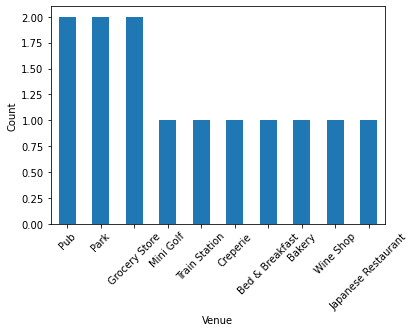

In [14]:
plt.figure()
nearby_venues['categories'].value_counts().plot(kind = 'bar', rot = 45)
plt.xlabel('Venue')
plt.ylabel('Count')
plt.show()

## Repeat the above step, but for all neighborhoods in London

In [15]:
nearby_venues_all = getNearbyVenues(names = london_neighborhoods['Neighborhood'], \
                                   latitudes = london_neighborhoods['Latitude'], \
                                   longitudes = london_neighborhoods['Longitude'])

Abbey Wood
Acton
Acton
Aldgate
Aldwych
Anerley
Angel
Angel
Archway
Arnos Grove
Arnos Grove
Balham
Bankside
Barbican
Barnes
Barnsbury
Battersea
Bayswater
Bedford Park
Belgravia
Bellingham
Belsize Park
Bermondsey
Bethnal Green
Blackfriars
Blackheath
Blackheath Royal Standard
Blackheath Royal Standard
Blackwall
Bloomsbury
Bounds Green
Bounds Green
Bow
Bowes Park
Brent Cross
Brent Cross
Brent Park
Brixton
Brixton
Brixton
Brockley
Bromley
Brompton
Brondesbury
Brunswick Park
Burroughs, The
Camberwell
Cambridge Heath
Camden Town
Canary Wharf
Cann Hall
Canning Town
Canonbury
Castelnau
Catford
Chalk Farm
Charing Cross
Charlton
Chelsea
Childs Hill
Chinatown
Chinbrook
Chingford
Chiswick
Church End
Church End
Clapham
Clerkenwell
Colindale
Colliers Wood
Colney Hatch
Colney Hatch
Covent Garden
Cricklewood
Crofton Park
Crossness
Crouch End
Crystal Palace
Crystal Palace
Crystal Palace
Cubitt Town
Custom House
Dalston
Dartford
De Beauvoir Town
Denmark Hill
Deptford
Dollis Hill
Dulwich
Ealing
Ealing
Ear

> First, I will check the size of the resulting data frame

In [16]:
print(nearby_venues_all.shape)
nearby_venues_all.head()

(12694, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Abbey Wood,51.4869,0.1075,Co-op Food,51.487650,0.113490,Grocery Store
1,Abbey Wood,51.4869,0.1075,Cheers Off License,51.486808,0.107396,Grocery Store
2,Abbey Wood,51.4869,0.1075,Red barbars shop,51.484588,0.103603,Cosmetics Shop
3,Abbey Wood,51.4869,0.1075,McLeod road/Bostall lane Bus Stop,51.487537,0.113441,Bus Stop
4,Abbey Wood,51.4869,0.1075,Meghna Tandoori,51.485709,0.101681,Indian Restaurant


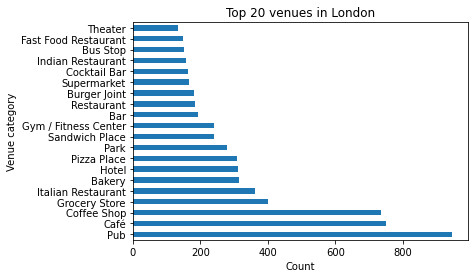

In [17]:
plt.figure()
nearby_venues_all['Venue Category'].value_counts()[0:20].plot(kind='barh')
plt.title('Top 20 venues in London')
plt.ylabel('Venue category')
plt.xlabel('Count')
plt.show()

> Then I will, check how many venues were returned for each neighborhood

In [18]:
nearby_venues_all.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Abbey Wood,6,6,6,6,6,6
Acton,110,110,110,110,110,110
Aldgate,87,87,87,87,87,87
Aldwych,61,61,61,61,61,61
Anerley,7,7,7,7,7,7
...,...,...,...,...,...,...
Wood Green,13,13,13,13,13,13
Woodford,41,41,41,41,41,41
Woodside Park,4,4,4,4,4,4


> I will also check how many unique venues were returned

In [19]:
print('There are {} uniques categories.'.format(len(nearby_venues_all['Venue Category'].unique())))

There are 292 uniques categories.


> And finally, I will check the neighborhood with highest number of venues

In [20]:
print('The neighborhood with highest number of venues is {}'.format(nearby_venues_all.groupby('Neighborhood').count().idxmax()['Venue']))

The neighborhood with highest number of venues is Holland Park


## Analyzing each neighborhood

In [21]:
# one hot encoding
london_onehot = pd.get_dummies(nearby_venues_all[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
london_onehot['Neighborhood'] = nearby_venues_all['Neighborhood'] 

first_col = london_onehot.pop('Neighborhood')

london_onehot.insert(0, 'Neighborhood', first_col)

london_onehot.head()

,Neighborhood,African Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,...,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Xinjiang Restaurant,Yoga Studio
0,Abbey Wood,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Abbey Wood,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Abbey Wood,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Abbey Wood,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Abbey Wood,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
london_grouped = london_onehot.groupby('Neighborhood').mean().reset_index()

num_top_venues = 5

for hood in london_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = london_grouped[london_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Abbey Wood----
                venue  freq
0       Grocery Store  0.50
1   Indian Restaurant  0.17
2      Cosmetics Shop  0.17
3            Bus Stop  0.17
4  African Restaurant  0.00


----Acton----
           venue  freq
0            Pub  0.08
1    Coffee Shop  0.07
2         Bakery  0.05
3           Café  0.05
4  Grocery Store  0.05


----Aldgate----
            venue  freq
0         Theater  0.08
1           Hotel  0.07
2  Ice Cream Shop  0.05
3    Cocktail Bar  0.05
4           Plaza  0.05


----Aldwych----
            venue  freq
0  Ice Cream Shop  0.07
1         Theater  0.07
2    Dessert Shop  0.05
3    Cocktail Bar  0.05
4           Hotel  0.05


----Anerley----
                  venue  freq
0         Grocery Store  0.14
1  Fast Food Restaurant  0.14
2     Convenience Store  0.14
3         Train Station  0.14
4             Gastropub  0.14


----Angel----
          venue  freq
0           Pub  0.16
1          Café  0.07
2   Coffee Shop  0.05
3  Cocktail Bar  0.03
4          

                 venue  freq
0          Coffee Shop  0.06
1                  Pub  0.06
2                 Café  0.05
3  Japanese Restaurant  0.05
4         Cocktail Bar  0.05


----Clerkenwell----
                venue  freq
0                 Pub  0.14
1         Coffee Shop  0.06
2                Café  0.06
3                 Bar  0.04
4  Italian Restaurant  0.03


----Colindale----
              venue  freq
0               Pub   0.2
1              Café   0.2
2        Hookah Bar   0.2
3  Asian Restaurant   0.2
4  Sushi Restaurant   0.2


----Colliers Wood----
              venue  freq
0               Bar  0.08
1     Grocery Store  0.08
2              Café  0.05
3  Sushi Restaurant  0.05
4       Coffee Shop  0.05


----Colney Hatch----
           venue  freq
0           Café  0.11
1  Grocery Store  0.09
2    Coffee Shop  0.07
3            Pub  0.05
4    Pizza Place  0.05


----Covent Garden----
            venue  freq
0  Ice Cream Shop  0.07
1         Theater  0.07
2    Dessert Shop  0.05

         venue  freq
0  Coffee Shop  0.08
1          Pub  0.07
2         Café  0.06
3       Bakery  0.04
4    Bookstore  0.04


----Hackney----
                venue  freq
0                 Pub  0.17
1                Café  0.11
2                Park  0.05
3  Italian Restaurant  0.04
4           Gastropub  0.04


----Hackney Central----
       venue  freq
0       Café  0.13
1   Platform  0.10
2        Pub  0.10
3  Wine Shop  0.05
4      Hotel  0.05


----Hackney Marshes----
       venue  freq
0       Café  0.14
1        Pub  0.14
2  Gastropub  0.09
3       Park  0.09
4   Bus Stop  0.05


----Hackney Wick----
       venue  freq
0       Café  0.14
1        Pub  0.14
2  Gastropub  0.09
3       Park  0.09
4   Bus Stop  0.05


----Haggerston----
          venue  freq
0           Pub  0.13
1   Coffee Shop  0.11
2          Café  0.06
3  Cocktail Bar  0.06
4   Pizza Place  0.04


----Hammersmith----
                  venue  freq
0           Coffee Shop  0.11
1                  Café  0.08
2     

                  venue  freq
0           Coffee Shop  0.09
1  Gym / Fitness Center  0.05
2                 Plaza  0.05
3                   Pub  0.05
4    Italian Restaurant  0.05


----Mayfair----
                  venue  freq
0           Coffee Shop  0.09
1  Gym / Fitness Center  0.05
2                 Plaza  0.05
3                   Pub  0.05
4    Italian Restaurant  0.05


----Maze Hill----
                  venue  freq
0                   Pub  0.13
1  Gym / Fitness Center  0.07
2                   Bar  0.04
3                 Hotel  0.04
4                Market  0.04


----Merton Park----
              venue  freq
0               Bar  0.08
1     Grocery Store  0.08
2              Café  0.05
3  Sushi Restaurant  0.05
4       Coffee Shop  0.05


----Middle Park----
                      venue  freq
0      Fast Food Restaurant  0.08
1                  Bus Stop  0.05
2  Mediterranean Restaurant  0.05
3          Department Store  0.05
4                  Platform  0.05


----Mile End----


----Shoreditch----
        venue  freq
0         Pub  0.21
1        Café  0.10
2        Park  0.08
3  Canal Lock  0.05
4       Canal  0.05


----Silvertown----
                venue  freq
0             Theater  0.33
1  Light Rail Station  0.33
2          Donut Shop  0.33
3   Outdoor Sculpture  0.00
4         Pastry Shop  0.00


----Snaresbrook----
                venue  freq
0  Chinese Restaurant  0.14
1            Tea Room  0.14
2          Restaurant  0.14
3            Bus Stop  0.14
4  English Restaurant  0.14


----Soho----
                  venue  freq
0           Coffee Shop  0.09
1  Gym / Fitness Center  0.05
2                 Plaza  0.05
3                   Pub  0.05
4    Italian Restaurant  0.05


----Somerstown----
         venue  freq
0       Garden  0.10
1         Park  0.10
2  Coffee Shop  0.07
3          Bar  0.07
4          Pub  0.05


----South Hackney----
       venue  freq
0       Café  0.14
1        Pub  0.14
2  Gastropub  0.09
3       Park  0.09
4   Bus Stop  0.05



           venue  freq
0           Café  0.12
1            Pub  0.11
2    Coffee Shop  0.09
3  Grocery Store  0.07
4    Pizza Place  0.05


----Well Hall----
                      venue  freq
0      Fast Food Restaurant  0.08
1                  Bus Stop  0.05
2  Mediterranean Restaurant  0.05
3          Department Store  0.05
4                  Platform  0.05


----West Brompton----
                 venue  freq
0               Bakery  0.09
1                  Pub  0.07
2   Italian Restaurant  0.07
3  Japanese Restaurant  0.04
4       Ice Cream Shop  0.04


----West Ealing----
                venue  freq
0         Coffee Shop  0.07
1         Pizza Place  0.05
2  Italian Restaurant  0.05
3                Park  0.04
4               Hotel  0.04


----West Green----
           venue  freq
0    Coffee Shop  0.13
1       Bus Stop  0.09
2            Pub  0.09
3  Train Station  0.04
4           Café  0.04


----West Hackney----
                venue  freq
0                 Pub  0.21
1           

In [23]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = london_grouped['Neighborhood']

for ind in np.arange(london_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(london_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Abbey Wood,Grocery Store,Indian Restaurant,Cosmetics Shop,Bus Stop,Farmers Market,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant
1,Acton,Pub,Coffee Shop,Café,Bakery,Grocery Store,Park,Pizza Place,Bookstore,Ice Cream Shop,Burger Joint
2,Aldgate,Theater,Hotel,Plaza,Ice Cream Shop,Cocktail Bar,Dessert Shop,Burger Joint,Indie Movie Theater,Boutique,Garden
3,Aldwych,Theater,Ice Cream Shop,Cocktail Bar,Burger Joint,Dessert Shop,Hotel,Plaza,Cosmetics Shop,Bakery,Liquor Store
4,Anerley,Convenience Store,Tram Station,Fast Food Restaurant,Supermarket,Gastropub,Train Station,Grocery Store,Department Store,Ethiopian Restaurant,Food & Drink Shop


# Clustering neighborhoods

## Run *k*-means to cluster the neighborhood into 5 clusters.

In [24]:
# set number of clusters
kclusters = 5

london_grouped_clustering = london_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(london_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 0, 0, 0, 0, 2, 0, 2, 0, 0], dtype=int32)

In [25]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

london_merged = london_neighborhoods

# merge to add latitude/longitude for each neighborhood
london_merged = london_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

london_merged.head() # check the last columns!

,Neighborhood,Borough,PostCode,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Abbey Wood,"Bexley, Greenwich",SE2,51.4869,0.107500,1.0,Grocery Store,Indian Restaurant,Cosmetics Shop,Bus Stop,Farmers Market,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant
1,Acton,"Ealing, Hammersmith and Fulham",W3,51.5114,-0.265717,0.0,Pub,Coffee Shop,Café,Bakery,Grocery Store,Park,Pizza Place,Bookstore,Ice Cream Shop,Burger Joint
1,Acton,"Ealing, Hammersmith and Fulham",W4,51.4927,-0.258000,0.0,Pub,Coffee Shop,Café,Bakery,Grocery Store,Park,Pizza Place,Bookstore,Ice Cream Shop,Burger Joint
6,Aldgate,City,EC3,51.5085,-0.125700,0.0,Theater,Hotel,Plaza,Ice Cream Shop,Cocktail Bar,Dessert Shop,Burger Joint,Indie Movie Theater,Boutique,Garden
7,Aldwych,Westminster,WC2,51.5085,-0.123382,0.0,Theater,Ice Cream Shop,Cocktail Bar,Burger Joint,Dessert Shop,Hotel,Plaza,Cosmetics Shop,Bakery,Liquor Store


In [39]:
london_merged.dropna(subset = ['Cluster Labels'], inplace = True)
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(london_merged['Latitude'], london_merged['Longitude'], london_merged['Neighborhood'], london_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster-1)],
        fill=True,
        fill_color=rainbow[int(cluster-1)],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Examine clusters

In [27]:
# Cluster 1
london_merged.loc[london_merged['Cluster Labels'] == 0, london_merged.columns[[0] + list(range(4, london_merged.shape[1]))]]

,Neighborhood,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Acton,-0.265717,0.0,Pub,Coffee Shop,Café,Bakery,Grocery Store,Park,Pizza Place,Bookstore,Ice Cream Shop,Burger Joint
1,Acton,-0.258000,0.0,Pub,Coffee Shop,Café,Bakery,Grocery Store,Park,Pizza Place,Bookstore,Ice Cream Shop,Burger Joint
6,Aldgate,-0.125700,0.0,Theater,Hotel,Plaza,Ice Cream Shop,Cocktail Bar,Dessert Shop,Burger Joint,Indie Movie Theater,Boutique,Garden
7,Aldwych,-0.123382,0.0,Theater,Ice Cream Shop,Cocktail Bar,Burger Joint,Dessert Shop,Hotel,Plaza,Cosmetics Shop,Bakery,Liquor Store
9,Anerley,-0.056950,0.0,Convenience Store,Tram Station,Fast Food Restaurant,Supermarket,Gastropub,Train Station,Grocery Store,Department Store,Ethiopian Restaurant,Food & Drink Shop
...,...,...,...,...,...,...,...,...,...,...,...,...,...
521,Winchmore Hill,-0.100000,0.0,Coffee Shop,Italian Restaurant,Supermarket,Pub,Bus Stop,Grocery Store,Pizza Place,Middle Eastern Restaurant,Bar,Bistro
523,Woodford,0.020000,0.0,Italian Restaurant,Grocery Store,Bar,Café,Chinese Restaurant,Supermarket,Indian Restaurant,Pub,Coffee Shop,Playground
523,Woodford,0.022500,0.0,Italian Restaurant,Grocery Store,Bar,Café,Chinese Restaurant,Supermarket,Indian Restaurant,Pub,Coffee Shop,Playground
527,Woodside Park,-0.166000,0.0,Soccer Field,Health & Beauty Service,Sports Club,Rugby Pitch,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farm


In [28]:
# Cluster 2
london_merged.loc[london_merged['Cluster Labels'] == 1, london_merged.columns[[0] + list(range(4, london_merged.shape[1]))]]

,Neighborhood,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Abbey Wood,0.1075,1.0,Grocery Store,Indian Restaurant,Cosmetics Shop,Bus Stop,Farmers Market,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant
70,Brunswick Park,-0.1441,1.0,Grocery Store,Park,Fish & Chips Shop,Hardware Store,Yoga Studio,Falafel Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit
124,Crossness,0.1075,1.0,Grocery Store,Indian Restaurant,Cosmetics Shop,Bus Stop,Farmers Market,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant
181,Friern Barnet,-0.1441,1.0,Grocery Store,Park,Fish & Chips Shop,Hardware Store,Yoga Studio,Falafel Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit
326,New Southgate,-0.1441,1.0,Grocery Store,Park,Fish & Chips Shop,Hardware Store,Yoga Studio,Falafel Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit
507,West Heath,0.1075,1.0,Grocery Store,Indian Restaurant,Cosmetics Shop,Bus Stop,Farmers Market,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant


In [29]:
# Cluster 3
london_merged.loc[london_merged['Cluster Labels'] == 2, london_merged.columns[[0] + list(range(4, london_merged.shape[1]))]]

,Neighborhood,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,Angel,-0.105518,2.0,Pub,Café,Coffee Shop,Cocktail Bar,Bar,Italian Restaurant,Park,Hotel,Breakfast Spot,Food Truck
10,Angel,-0.094400,2.0,Pub,Café,Coffee Shop,Cocktail Bar,Bar,Italian Restaurant,Park,Hotel,Breakfast Spot,Food Truck
15,Arnos Grove,-0.144100,2.0,Grocery Store,Greek Restaurant,Bus Stop,Café,Hardware Store,Pub,Fish & Chips Shop,Paper / Office Supplies Store,Park,Golf Course
15,Arnos Grove,-0.130620,2.0,Grocery Store,Greek Restaurant,Bus Stop,Café,Hardware Store,Pub,Fish & Chips Shop,Paper / Office Supplies Store,Park,Golf Course
18,Barbican,-0.105518,2.0,Pub,Café,Coffee Shop,Bar,Food Truck,Hotel,Italian Restaurant,Vietnamese Restaurant,Pizza Place,Cocktail Bar
...,...,...,...,...,...,...,...,...,...,...,...,...,...
508,West Hendon,-0.256920,2.0,Asian Restaurant,Café,Pub,Hookah Bar,Sushi Restaurant,Event Space,Exhibit,Falafel Restaurant,Farm,Farmers Market
510,West Norwood,-0.102700,2.0,Café,Pub,Grocery Store,Breakfast Spot,Bakery,Flower Shop,Fish & Chips Shop,Sporting Goods Shop,Farmers Market,Supermarket
516,Whitechapel,-0.061773,2.0,Café,Pub,Coffee Shop,Grocery Store,Pizza Place,Bakery,Turkish Restaurant,Gym,Fast Food Restaurant,Music Store
522,Wood Green,-0.116700,2.0,Indian Restaurant,Café,Bakery,Light Rail Station,Pub,Park,Italian Restaurant,Convenience Store,Restaurant,Train Station


In [30]:
# Cluster 4
london_merged.loc[london_merged['Cluster Labels'] == 3, london_merged.columns[[0] + list(range(4, london_merged.shape[1]))]]

,Neighborhood,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
51,Blackheath Royal Standard,0.017500,3.0,Park,Transportation Service,Bus Stop,Fast Food Restaurant,Pub,Deli / Bodega,Ethiopian Restaurant,Food Court,Food & Drink Shop,Flower Shop
51,Blackheath Royal Standard,0.020900,3.0,Park,Transportation Service,Bus Stop,Fast Food Restaurant,Pub,Deli / Bodega,Ethiopian Restaurant,Food Court,Food & Drink Shop,Flower Shop
96,Chinbrook,0.020900,3.0,Pub,Bus Stop,Fast Food Restaurant,Park,Flower Shop,Flea Market,Fish Market,Food & Drink Shop,Fish & Chips Shop,Film Studio
147,East Dulwich,-0.068767,3.0,Pub,Park,Grocery Store,Bus Stop,Cycle Studio,Fast Food Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant
249,Horn Park,0.020900,3.0,Pub,Bus Stop,Fast Food Restaurant,Park,Flower Shop,Flea Market,Fish Market,Food & Drink Shop,Fish & Chips Shop,Film Studio
281,Lee,0.020900,3.0,Pub,Bus Stop,Fast Food Restaurant,Park,Flower Shop,Flea Market,Fish Market,Food & Drink Shop,Fish & Chips Shop,Film Studio
347,Oakleigh Park,-0.183320,3.0,Park,Golf Course,Metro Station,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farm,Yoga Studio
468,Totteridge,-0.183320,3.0,Park,Golf Course,Metro Station,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farm,Yoga Studio
514,Whetstone,-0.183320,3.0,Park,Golf Course,Metro Station,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farm,Yoga Studio


In [31]:
# Cluster 5
london_merged.loc[london_merged['Cluster Labels'] == 4, london_merged.columns[[0] + list(range(4, london_merged.shape[1]))]]

,Neighborhood,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
50,Blackheath,0.0175,4.0,Transportation Service,Yoga Studio,Fast Food Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farm,Farmers Market,Film Studio
267,Kidbrooke,0.0175,4.0,Transportation Service,Yoga Studio,Fast Food Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farm,Farmers Market,Film Studio
512,Westcombe Park,0.0175,4.0,Transportation Service,Yoga Studio,Fast Food Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farm,Farmers Market,Film Studio


## Conclusions
> Taking into account the couples preferences, I would advise them to settle in any of the neighborhoods in cluster 4. 
This cluster is composed of neighborhoods with a lot of open spaces (Parks) and even golf courses.  

# COVID-19 risk assessment
> Finally, I will asses the number of cases sorrounding the London boroughs

In [32]:
!wget -q -O 'coronavirus_data.json' https://coronavirus.data.gov.uk/downloads/json/coronavirus-cases_latest.json
print('Data downloaded!')

Data downloaded!


In [33]:
with open('coronavirus_data.json') as corona_json:
    corona = json.load(corona_json)

corona

{'metadata': {'lastUpdatedAt': '2020-07-12T15:04:23.847464Z',
  'disclaimer': 'Deaths and lab-confirmed case counts and rates for England and subnational areas are provided by Public Health England. All data for the rest of the UK are provided by the devolved administrations. Maps include Ordnance Survey data © Crown copyright and database right 2020 and Office for National Statistics data © Crown copyright and database right 2020. Daily and total case counts are as of 12 July 2020. Daily and total deaths are as of 11 July 2020. Northern Ireland do not report Covid-19 data at weekends. Daily figures for tests and positive cases are therefore GB only. Historical Northern Ireland data are included in the UK cumulative totals. Any cases or deaths in Northern Ireland over the weekend will be included in the cumulative totals on Monday.\n'},
 'dailyRecords': {'areaName': 'United Kingdom',
  'totalLabConfirmedCases': 289603,
  'dailyLabConfirmedCases': 650},
 'ltlas': [{'areaCode': 'E0900003

> Check first example

In [34]:
corona_data = corona['ltlas']
corona_data[0]

{'areaCode': 'E09000033',
 'areaName': 'Westminster',
 'specimenDate': '2020-07-11',
 'dailyLabConfirmedCases': 0,
 'previouslyReportedDailyCases': None,
 'changeInDailyCases': None,
 'totalLabConfirmedCases': 778,
 'previouslyReportedTotalCases': None,
 'changeInTotalCases': None,
 'dailyTotalLabConfirmedCasesRate': 304.7}

> Parse Json data to pandas data frame

In [35]:
# define the dataframe columns
column_names = ['Borough', 'DailyTotalLabConfirmedCasesRate', 'Date'] 

# instantiate the dataframe
corona_df = pd.DataFrame(columns=column_names)

for data in corona_data:
    borough = data['areaName']
    dailycases = data['dailyTotalLabConfirmedCasesRate']  
    date = data['specimenDate']
    corona_df = corona_df.append({'Borough': borough,
                                  'DailyTotalLabConfirmedCasesRate': dailycases,
                                  'Date' : date}, ignore_index=True)
corona_df.head()

,Borough,DailyTotalLabConfirmedCasesRate,Date
0,Westminster,304.7,2020-07-11
1,Wandsworth,354.7,2020-07-11
2,Waltham Forest,368.3,2020-07-11
3,Tower Hamlets,257.5,2020-07-11
4,Sutton,490.9,2020-07-11


> Check which unique boroughs are in cluster 4

In [36]:
temp = london_merged.loc[london_merged['Cluster Labels'] == 3, london_merged.columns[[0] + list(range(4, london_merged.shape[1]))]]['Neighborhood']

print('The unique boroughs in cluster 4 are {}'.format(london_neighborhoods[london_neighborhoods['Neighborhood'].isin(temp)]['Borough'].unique()))

The unique boroughs in cluster 4 are ['Greenwich' 'Lewisham' 'Southwark' 'Greenwich, Lewisham' 'Barnet']


> Check the current daily rate of COVID-19 cases in each borough

In [37]:
greenwich_covid_rate = int(corona_df[corona_df['Borough'] == 'Greenwich'].sort_values(['DailyTotalLabConfirmedCasesRate', 'Date'], ascending = False).drop_duplicates('Borough', keep = 'first')['DailyTotalLabConfirmedCasesRate'])
lewisham_covid_rate = int(corona_df[corona_df['Borough'] == 'Lewisham'].sort_values(['DailyTotalLabConfirmedCasesRate', 'Date'], ascending = False).drop_duplicates('Borough', keep = 'first')['DailyTotalLabConfirmedCasesRate'])
southwark_covid_rate = int(corona_df[corona_df['Borough'] == 'Southwark'].sort_values(['DailyTotalLabConfirmedCasesRate', 'Date'], ascending = False).drop_duplicates('Borough', keep = 'first')['DailyTotalLabConfirmedCasesRate'])
barnet_covid_rate = int(corona_df[corona_df['Borough'] == 'Barnet'].sort_values(['DailyTotalLabConfirmedCasesRate', 'Date'], ascending = False).drop_duplicates('Borough', keep = 'first')['DailyTotalLabConfirmedCasesRate'])

print('The current daily rate of COVID-19 infections in Greenwich is {}'.format(greenwich_covid_rate))
print('The current daily rate of COVID-19 infections in Lewisham is {}'.format(lewisham_covid_rate))
print('The current daily rate of COVID-19 infections in Southwark is {}'.format(southwark_covid_rate))
print('The current daily rate of COVID-19 infections in Barnet is {}'.format(barnet_covid_rate))

The current daily rate of COVID-19 infections in Greenwich is 334
The current daily rate of COVID-19 infections in Lewisham is 395
The current daily rate of COVID-19 infections in Southwark is 456
The current daily rate of COVID-19 infections in Barnet is 408


In [38]:
london_neighborhoods[london_neighborhoods['Neighborhood'].isin(temp)]

,Neighborhood,Borough,PostCode,Latitude,Longitude
51,Blackheath Royal Standard,Greenwich,SE3,51.4672,0.017500
51,Blackheath Royal Standard,Greenwich,SE12,51.4448,0.020900
96,Chinbrook,Lewisham,SE12,51.4448,0.020900
147,East Dulwich,Southwark,SE22,51.4521,-0.068767
249,Horn Park,"Greenwich, Lewisham",SE12,51.4448,0.020900
281,Lee,Lewisham,SE12,51.4448,0.020900
347,Oakleigh Park,Barnet,N20,51.6333,-0.183320
468,Totteridge,Barnet,N20,51.6333,-0.183320
514,Whetstone,Barnet,N20,51.6333,-0.183320


# Conclusions
> Taking into account the couple's preferences and the current daily rate of COVID-19 infection, I would recommend the couple to find a real-estate in the Greenwhich or Lewisham boroughs, potentially Blackheath Royal Standard. 